# Rock Physics Q-inversion of a volcanic flow

In [2]:
from importlib import reload
import volcaniQ as vq
import matplotlib.pyplot as plt
import numpy as np

In [62]:
reload(vq)
data = vq.CleanReadCSV()

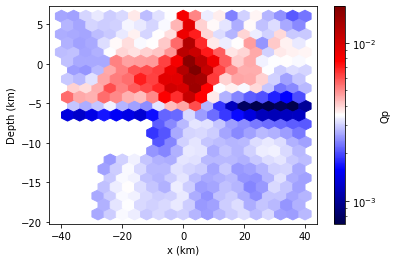

<Figure size 3032.64x3032.64 with 0 Axes>

In [63]:
data.hexplot(plot="Qp", direction="y", value=-1., func=(lambda x: 1/x), bins='log', grid=20)

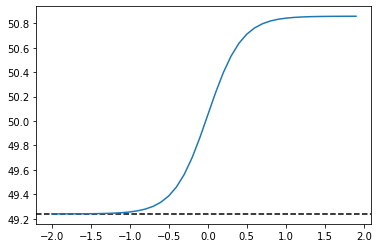

In [68]:
model1 = vq.RockPhysicsModel(dry_modulus=20.,shear_modulus=20, mineral_modulus=38, porosity=0.2, density=2.65)
model1.plot(fluid_modulus=2.5, epsilon=.03, tau=1)

In [66]:
highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]
mod = highQpdata.K
she = highQsdata.μ
mod.mean(), she.mean()

<ipython-input-66-49cd03391929>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQpdata = data.data[data.data.Qp.notnull()][data.data.Qp>800]
<ipython-input-66-49cd03391929>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  highQsdata = data.data[data.data.Qp.notnull()][data.data.Qs>1000]


(43.68873573573574, 26.02604200853298)